# Spatial cell-cell interaction tutorial


## 1. Add image, coordinates, and significant Ligand-Receptors from CPDB

In [1]:
import stlearn as st
import pandas as pd
# read in visium dataset downloaded from: support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Breast_Cancer_Block_A_Section_1
data = st.Read10X("C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## 2 Preprocessing


### 2.1. filter, normalize, scale & PCA

In [2]:
st.pp.filter_genes(data,min_cells=0.01*data.n_vars)
data.obsm['filtered'] = pd.DataFrame(data.X.toarray(), index=data.obs_names, columns=data.var_names)
st.pp.normalize_total(data)
data.obsm['normalized'] = pd.DataFrame(data.X.toarray(), index=data.obs_names, columns=data.var_names)
#import scipy as sc
#data.obsm['normalized'] = data.obsm['normalized'].apply(sc.stats.zscore, axis=0)
st.pp.log1p(data)
st.pp.scale(data)
st.em.run_pca(data,n_comps=50)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X
Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


### 2.2. add morphology information

In [4]:
st.pp.tiling(data,out_path="./temp_tiling",crop_size=40)
st.pp.extract_feature(data)
st.spatial.morphology.adjust(data,use_data='X_pca',radius=50,method="mean")
st.pp.neighbors(data,n_neighbors=25,use_rep='X_pca_morphology')
# upload image without background for plotting
st.add.image(adata=data, imgpath="C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1\\spatial\\tissue_hires_nobg.png",
            library_id="V1_Breast_Cancer_Block_A_Section_1",visium=True)

Tiling image: 100%|███████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
Extract feature: 100%|████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|█████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


The data adjusted by morphology is added to adata.obsm['X_pca_morphology']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
Added tissue image to the object!


## 3. Cell-cell interaction analysis

### 3.1 Cell type heterogeneity

In [5]:
st.tl.clustering.louvain(data)

Applying Louvain clustering ...
Louvain clustering is done! The labels are stored in adata.obs['louvain']


#### Count the density of cell types in user defined number of windows (e.g. num=30 means 30x30 windows across the tissue)

In [6]:
st.tl.cci.het.count(data, use_clustering='louvain', num_row=40, num_col=40)

Counts for cluster (cell type) diversity stored into data.uns['het']


AnnData object with n_obs × n_vars = 3813 × 11690
    obs: 'in_tissue', 'array_row', 'array_col', 'sum_counts', 'imagecol', 'imagerow', 'tile_path', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'cpdb', 'lr', 'neighbors', 'louvain', 'het'
    obsm: 'spatial', 'filtered_counts', 'filtered', 'normalized', 'X_pca', 'X_tile_feature', 'X_morphology', 'X_pca_morphology'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

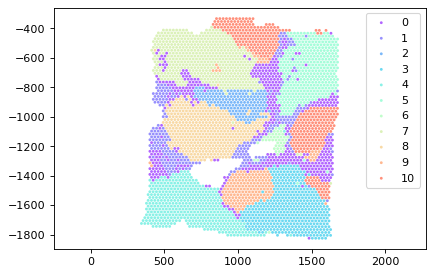

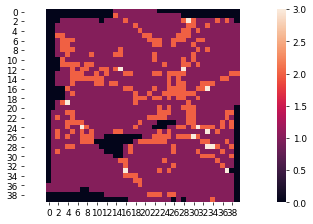

In [7]:
st.pl.het_plot(data, use_cluster='louvain', use_het='het', dpi=80, name='het_louvain', output='.')

### 3.2 Cell type diversity based on transferred labels

#### label transfer from a published breast cancer dataset for all spots

In [8]:
# Read in the spot/cell type predictions based on label transfer
data.obs['predictions'] = pd.read_csv('predictions.csv', sep='\t')

#### plot the transferred labels for each spot

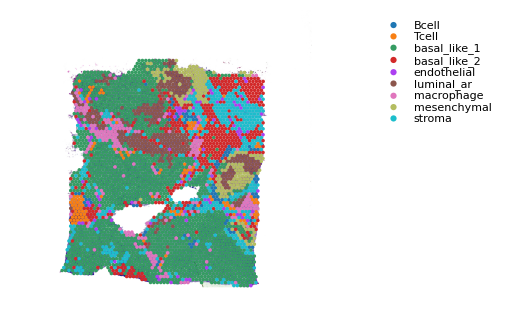

In [9]:
st.pl.cluster_plot(data,use_label="predictions", dpi=100, name='label_transfer', output='.')

Counts for cluster (cell type) diversity stored into data.uns['het']


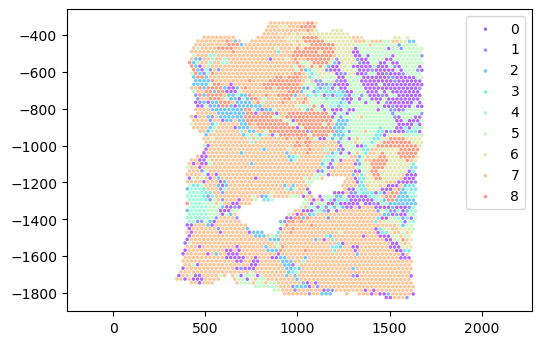

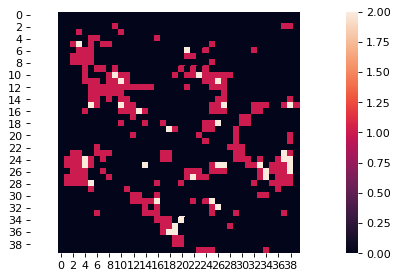

In [10]:
st.tl.cci.het.count(data, use_clustering='predictions', use_clusters=['Bcell', 'Tcell', 'macrophage'], num_row=40, num_col=40)
st.pl.het_plot(data, use_cluster='predictions', use_het='het', dpi=100, name='het_prediction', output='.')

### 3.3 Clustering based on Ligand-Receptor (L-R) co-expression

#### cluster spatial spots based on the proportion of known ligand-receptor co-expression among the neighbouring spots

In [11]:
# run cellphoneDB with morphology adjusted louvain clustering results, to get "means.txt"
st.add.lr(adata=data, cpdb_filepath = "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1\\cpdb\\means.txt", sep="\t")
st.tl.cci.base.lr(adata=data, use_data='normalized', threshold=1, distance=30)

cpdb results added to adata.uns['cpdb']
Added ligand receptor pairs to adata.uns['lr'].
Altogether 412 valid L-R pairs
L-R interactions with neighbours are counted and stored into adata\.obsm['lr_neighbours']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
Applying Louvain clustering ...
Louvain clustering is done! The labels are stored in adata.obs['louvain']
Spatial distribution of LR co-expression is written to adata.obsm['lr_neighbours']
Result of LR-clustering is kept in adata.obs['lr_neighbours_louvain']
The largest expressed LR neighbouring cluster is:  3


AnnData object with n_obs × n_vars = 3813 × 11690
    obs: 'in_tissue', 'array_row', 'array_col', 'sum_counts', 'imagecol', 'imagerow', 'tile_path', 'louvain', 'predictions', 'lr_neighbours_louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'cpdb', 'lr', 'neighbors', 'louvain', 'het', 'tmp_color', 'lr_neighbours_louvain_max'
    obsm: 'spatial', 'filtered_counts', 'filtered', 'normalized', 'X_pca', 'X_tile_feature', 'X_morphology', 'X_pca_morphology', 'lr_neighbours'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

#### plot the CCI clustering results and highlight the largest expressed cluster

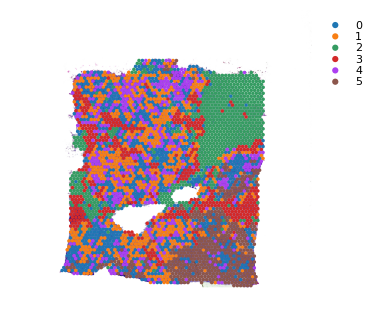

In [12]:
st.pl.cluster_plot(data,use_label="lr_neighbours_louvain", dpi=100)

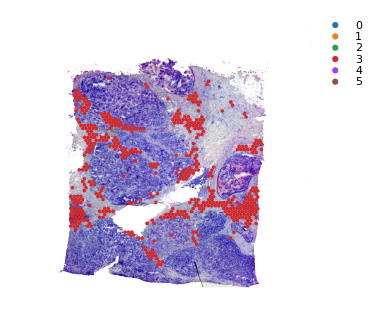

In [13]:
st.pl.cluster_plot(data,use_label="lr_neighbours_louvain",list_cluster=[data.uns['lr_neighbours_louvain_max']], dpi=100, name='lr_neighbours_louvain', output='.')

#### List the top 15 differentiated L-R pairs in all CCI clusters

In [14]:
import scanpy as sc
from anndata import AnnData
rank_test = AnnData(data.obsm['lr_neighbours'])
rank_test.obs['lr_neighbours_louvain'] = data.obs['lr_neighbours_louvain']
sc.tl.rank_genes_groups(rank_test, 'lr_neighbours_louvain', method='t-test')
pd.DataFrame(rank_test.uns['rank_genes_groups']['names']).iloc[0:15,]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,0,1,2,3,4,5
0,COPA_CD74,DAG1_LGALS9,CCL5_ACKR1,LGALS9_LRP1,SORT1_GRN,CEACAM6_CEACAM6
1,CD74_COPA,LGALS9_DAG1,ACKR1_CCL5,LRP1_LGALS9,GRN_SORT1,CEACAM6_CEACAM6
2,APP_CD74,SLC1A5_LGALS9,CCL2_ACKR1,LRP1_MDK,COPA_SORT1,CD74_COPA
3,CD74_APP,LGALS9_SLC1A5,ACKR1_CCL2,MDK_LRP1,SORT1_COPA,COPA_CD74
4,CD74_MIF,CD47_LGALS9,ESAM_ESAM,GRN_TNFRSF1B,CD74_COPA,SPP1_CD44
5,MIF_CD74,LGALS9_CD47,ESAM_ESAM,TNFRSF1B_GRN,COPA_CD74,CD44_SPP1
6,RIPK1_TNFSF10,LGALS9_CD44,PGF_NRP2,CXCL12_CXCR4,CD74_APP,CD74_MIF
7,TNFSF10_RIPK1,CD44_LGALS9,NRP2_PGF,CXCR4_CXCL12,APP_CD74,MIF_CD74
8,TNFRSF1A_GRN,COLEC12_LGALS9,PDGFA_PDGFRA,LGALS9_CD44,CD74_MIF,TNFRSF1A_GRN
9,GRN_TNFRSF1A,LGALS9_COLEC12,PDGFRA_PDGFA,CD44_LGALS9,MIF_CD74,GRN_TNFRSF1A


#### Violin plot of top differentiated L-R pairs neighbouring counts in each CCI cluster

C:\Users\uqjxu8\AppData\Local\Continuum\anaconda3\envs\stlearn\lib\site-packages\stlearn\plotting\cci_plot.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violin['cci_cluster'] = adata.obs['lr_neighbours_' + use_cluster]


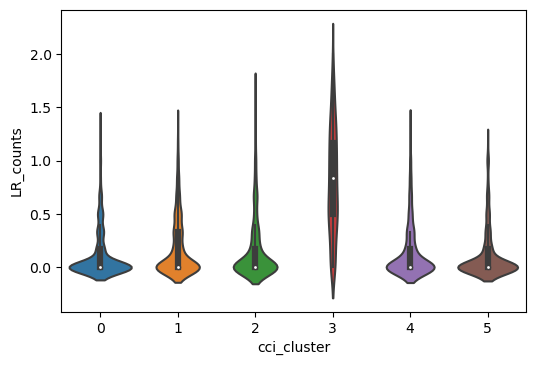

In [15]:
st.pl.violin_plot(data, lr='CXCR4_CXCL12', use_cluster='louvain', dpi=100, name='violin', output='.')

#### barplot to show the cell type (according to label transfer) compositions in each CCI cluster

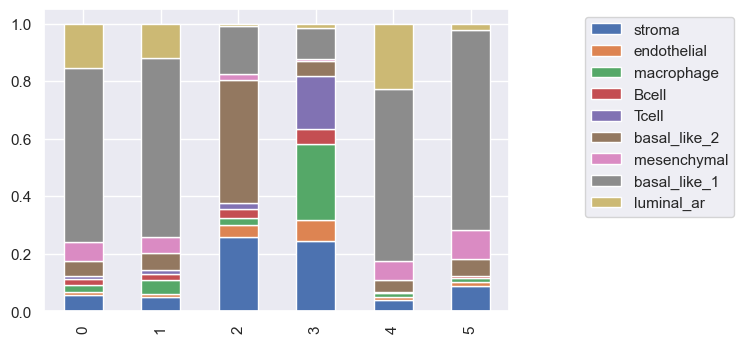

In [16]:
st.pl.stacked_bar_plot(data, use_annotation='predictions', dpi=100, name='stacked_bar', output='.')

#### Merge results from cci clustering and cell type heterogeneity

In [17]:
st.tl.cci.merge(data, use_lr='lr_neighbours_louvain_max', use_het='het')

Results of spatial interaction analysis has been written to adata.uns['merged']


AnnData object with n_obs × n_vars = 3813 × 11690
    obs: 'in_tissue', 'array_row', 'array_col', 'sum_counts', 'imagecol', 'imagerow', 'tile_path', 'louvain', 'predictions', 'lr_neighbours_louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'cpdb', 'lr', 'neighbors', 'louvain', 'het', 'tmp_color', 'lr_neighbours_louvain_max', 'merged'
    obsm: 'spatial', 'filtered_counts', 'filtered', 'normalized', 'X_pca', 'X_tile_feature', 'X_morphology', 'X_pca_morphology', 'lr_neighbours'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

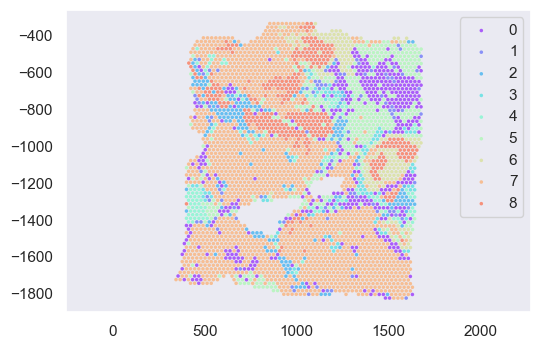

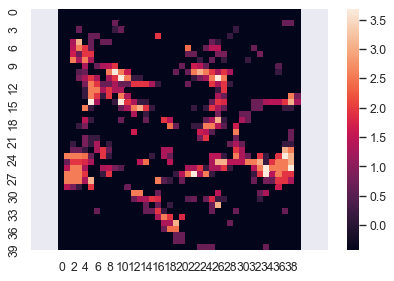

In [18]:
st.pl.het_plot(data, use_cluster='predictions', use_het='merged', dpi=100, name='final', output='.')

#### L-R expression summary across all spots

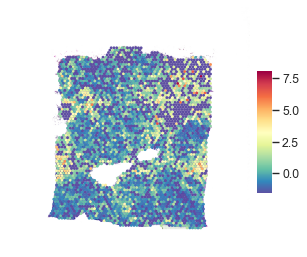

In [19]:
st.pl.gene_plot(data, genes=['CXCL12','CXCR4'], method="CumSum", dpi=80)

C:\Users\uqjxu8\AppData\Local\Continuum\anaconda3\envs\stlearn\lib\site-packages\stlearn\plotting\gene_plot.py:146: UserWarning: We removed IL34 because they not exist in the data
  warnings.warn("We removed " + gene +


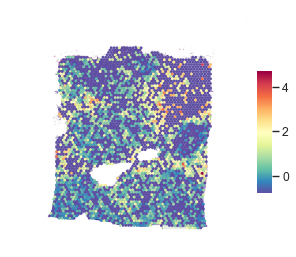

In [20]:
st.pl.gene_plot(data, genes=['IL34','CSF1R'], method="CumSum", dpi=80)

C:\Users\uqjxu8\AppData\Local\Continuum\anaconda3\envs\stlearn\lib\site-packages\stlearn\plotting\gene_plot.py:146: UserWarning: We removed CTLA4 because they not exist in the data
  warnings.warn("We removed " + gene +


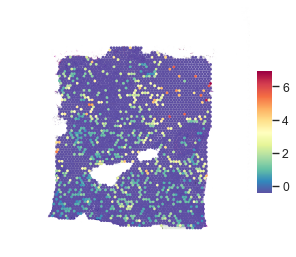

In [21]:
st.pl.gene_plot(data, genes=['CTLA4','CD86'], method="CumSum", dpi=80)

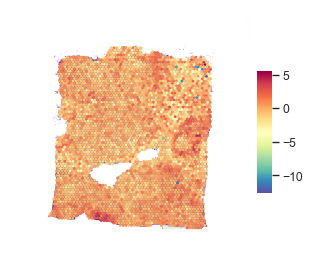

In [22]:
st.pl.gene_plot(data, genes=['GAPDH','ACTB'], method="CumSum", dpi=80)